In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.1
GAMMA = 0.99
EPS = 1e-8

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            done_mask = torch.cat(tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_best_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_best_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

1000

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

200

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        
        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in    50 steps, reward -365.41
  2 Episode in   114 steps, reward -548.22
  3 Episode in   190 steps, reward -548.29
  4 Episode in   246 steps, reward -556.05
  5 Episode in   322 steps, reward -547.31
  6 Episode in   378 steps, reward -512.56
  7 Episode in   456 steps, reward -846.64
  8 Episode in   511 steps, reward -461.09
  9 Episode in   561 steps, reward -472.05
 10 Episode in   613 steps, reward -395.46
 11 Episode in   667 steps, reward -424.30
 12 Episode in   728 steps, reward -543.43
 13 Episode in   788 steps, reward -517.25
 14 Episode in   846 steps, reward -497.55
 15 Episode in   934 steps, reward -988.88
 16 Episode in  1014 steps, reward -914.70
 17 Episode in  1073 steps, reward -574.05
 18 Episode in  1159 steps, reward -888.45
 19 Episode in  1209 steps, reward -477.43
 20 Episode in  1278 steps, reward -583.21
 21 Episode in  1361 steps, reward -812.62
 22 Episode in  1443 steps, reward -816.76

============  Start Learning  ============

 23 Episo

194 Episode in 95301 steps, reward 236.23
195 Episode in 95585 steps, reward 225.06
196 Episode in 95780 steps, reward 220.93
197 Episode in 96021 steps, reward 237.51
198 Episode in 96376 steps, reward 202.46
199 Episode in 96671 steps, reward 229.30
200 Episode in 96913 steps, reward 235.61
201 Episode in 97166 steps, reward 196.93
202 Episode in 97395 steps, reward 221.62
203 Episode in 97708 steps, reward 168.85
204 Episode in 97959 steps, reward 269.90
205 Episode in 98243 steps, reward 247.61
206 Episode in 98816 steps, reward 198.36
207 Episode in 99020 steps, reward 186.45
208 Episode in 99232 steps, reward 190.22
209 Episode in 100203 steps, reward 183.23
210 Episode in 100374 steps, reward 232.39
211 Episode in 100566 steps, reward 192.67
212 Episode in 101023 steps, reward 171.18
213 Episode in 101812 steps, reward 191.19
214 Episode in 102051 steps, reward 188.11
215 Episode in 102328 steps, reward 201.48
216 Episode in 102595 steps, reward 236.45
217 Episode in 102776 step

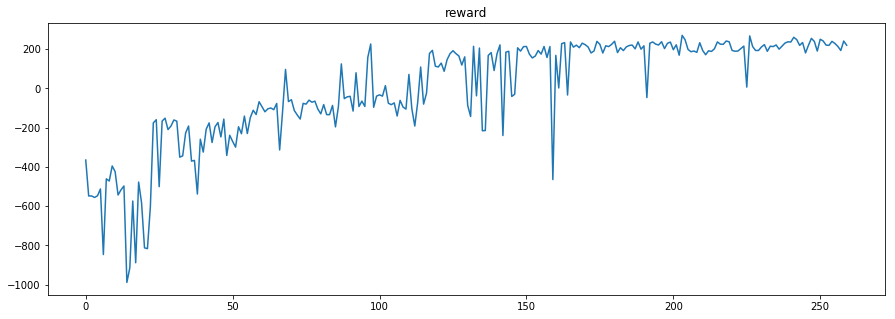

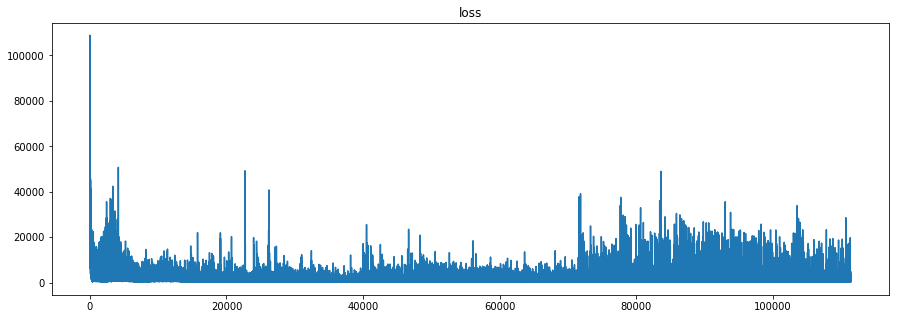

In [11]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()

In [12]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 452, 0.05),
    ('MountainCar-v0', 193, 0.1),
    ('LunarLander-v2', 260, 0.1)
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 452, 0.05),
 ('MountainCar-v0', 193, 0.1),
 ('LunarLander-v2', 260, 0.1)]